# <center><u>Adios 3 Wind Speed Uncertainty Methods</u></center>

Ok, here is what we were given by Bill for calculating the upper and lower uncertainty values for wind speed.

$$
\begin{align}
u_1(t_k) &= \left( 1 - \delta\sqrt{2 \over \pi} \right) U_{10}(t_k) \\
u_2(t_k) &= U_{10}(t_k) \\
u_3(t_k) &= \left( 1 + \delta\sqrt{2 \over \pi} \right) U_{10}(t_k) \\
\end{align}
$$

This presumably links back to the Rayleigh distribution functions, which are shown in bills document as follows:

$$
\begin{align}
\sigma &= \sqrt{2 \over \pi} \overline U_{10} \\
PDF: \space f(u_j) &= { u_j \over \sigma^2 } e^ \left( -{u_j}^2 / 2 \sigma ^ 2 \right) \\
CDF: \space F(u_j) &= 1 - e^ \left( -{u_j}^2 / 2 \sigma ^ 2 \right) \\
\end{align}
$$

Let's look closer at the calculation for our Rayleigh parameter ($ \sigma $).  This is the one that was used to calculate the upper and lower bounds of our uncertainty.
<br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br>

Ok, I believe $ \sigma $, calculated from average wind speed $ \overline U_{10} $, is based on the Mean equation for the Rayleigh distribution.  So for completeness:

$$
\begin{align}
Mean &= \sigma \sqrt{\pi \over 2} \\
\sigma \sqrt{\pi \over 2} &= \overline U_{10} \\
\sigma &= {\overline U_{10} \over \sqrt{\pi \over 2} }\\
\sigma &= {\overline U_{10} \over {\left( \sqrt \pi \over \sqrt 2 \right) } } \\
\sigma &= {\overline U_{10} \sqrt 2 \over \sqrt \pi } \\
\sigma &= \sqrt {2 \over \pi } \overline U_{10} \\
\end{align}
$$

Now let's get our distribution functions going.

In [3]:
import numpy as np

In [4]:
def rayleigh_sigma_from_wind(avg_speed):
    return np.sqrt(2.0 / np.pi) * avg_speed

def rayleigh_pdf(x, sigma):
    return (x / sigma ** 2.0) * np.exp((-1.0 / 2.0) * (x ** 2.0 / sigma ** 2.0))

def rayleigh_cdf(x, sigma):
    return 1.0 - np.exp((-1.0 / 2.0) * (x ** 2.0 / sigma ** 2.0))

In [5]:
print rayleigh_pdf(2.0, 2.0)
print rayleigh_cdf(2.0, 2.0)

print rayleigh_pdf(3.0, 3.0)
print rayleigh_cdf(3.0, 3.0)

0.303265329856
0.393469340287
0.202176886571
0.393469340287


Ok, this seems to track the peaks that I am seeing in the example graphs for the Rayleigh distribution.

Alright, the PDF and the CDF seem to work ok, and the CDF gets us pretty close to what we want.<br>
The nature of the CDF is that we plug in a wind speed, and it gives us the fraction of speeds contained in our distribution that are lower than that speed.

But what we would really like to know is at what point our CDF gets past a certain percentage of the distribution.
In other words, we would like to plug in a fractional amount and get the wind speed that is immediately above that fractional amount in our distribution.<br>
So the function that we would really like to implement is a Quantile (aka. inverse CDF or percent point function)<br>
This will allow us to give a percent value (say, 20%) and come up with a wind speed at which 20% of our statistical speeds should fall below

The Rayleigh distribution has a quantile function described as:

$$
\begin{align}
Q(F; \sigma) &= \sigma \sqrt{ -ln [(1 -F)^2]}
\end{align}
$$

There are problems I see with this, such as taking the square root of a negative.  But if we just take the magnitude of the imaginary component, we might be ok.  (Unsure of how this will play out in practice however)<br>
Alright, let's give it a try:

In [6]:
def rayleigh_quantile(f, sigma):
    return (sigma * np.sqrt((-1.0 * np.log((1.0 - f) ** 2.0)) + 0j)).real

In [7]:
percent_value = rayleigh_cdf(0.5, 0.5)
print percent_value
print rayleigh_quantile(percent_value, 0.5)  # should be our original value of 0.5
print

percent_value = rayleigh_cdf(1.0, 1.0)
print percent_value
print rayleigh_quantile(percent_value, 1.0)  # should be our original value of 1.0
print

percent_value = rayleigh_cdf(2.0, 2.0)
print percent_value
print rayleigh_quantile(percent_value, 2.0)  # should be our original value of 2.0
print

percent_value = rayleigh_cdf(4.0, 4.0)
print percent_value
print rayleigh_quantile(percent_value, 4.0)  # should be our original value of 4.0
print

percent_value = rayleigh_cdf(20.0, 15.9576912161)
print percent_value
print rayleigh_quantile(percent_value, 15.9576912161)  # should be our original value of 20.0
print


0.393469340287
0.5

0.393469340287
1.0

0.393469340287
2.0

0.393469340287
4.0

0.544061872232
20.0



Alright, our quantile function seems to be a pretty good inverse of the CDF
<br><br><br><br>

## Putting it all together

Ok, here is what we will do.

For each wind in our time series:
- assume that the speed is an average wind speed for that time sample
- compute our $ \sigma $ value based on average wind speed
- compute our high and low values based on the percent uncertainty we would like to represent using the Rayleigh quantile function

Let's give this a try using somewhat reasonable values.

In [8]:
U_10 = 30.0  # right now we just use an arbitrary value for average wind speed.
percent_uncertainty = 0.1  # ten percent

sigma = rayleigh_sigma_from_wind(U_10)
print U_10, sigma

30.0 23.9365368241


In [9]:
low = rayleigh_quantile(0.5 - percent_uncertainty, sigma)  # wind speed at 40% of our distribution
high = rayleigh_quantile(0.5 + percent_uncertainty, sigma)  # wind speed at 60% of our distribution
print low, high

24.1942771369 32.4035775011


Alright, now let's try and plot some wind speeds with their associated uncertainty thresholds to give us a visual feel for how it might fit our distribution.
<br><br><br><br><br><br><br><br><br><br><br><br><br><br>

In [10]:
from pylab import *

In [11]:
%matplotlib inline

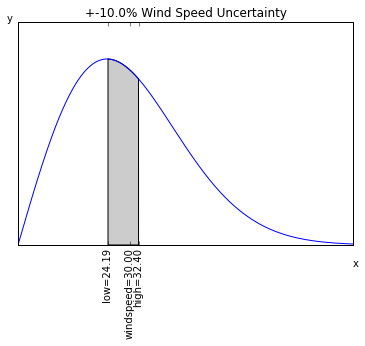

In [12]:
ax = subplot(111)

# Initial wind conditions
ws = 30.0
pu = 0.1

sigma = rayleigh_sigma_from_wind(ws)
height = rayleigh_pdf(sigma, sigma) * 1.2
width = ws * 3.0

x = arange(0, width, 0.01)
y = rayleigh_pdf(x, sigma)

low = rayleigh_quantile(0.5 - pu, rayleigh_sigma_from_wind(ws))
high = rayleigh_quantile(0.5 + pu, rayleigh_sigma_from_wind(ws))
plot(x, y, linewidth=1)

# make the shaded region
ix = arange(low, high, 0.01)
iy = rayleigh_pdf(ix, sigma)
verts = [(low,0)] + list(zip(ix,iy)) + [(high,0)]
poly = Polygon(verts, facecolor='0.8', edgecolor='k')
ax.add_patch(poly)

axis([0, width, 0, height])
figtext(0.9, 0.05, 'x')
figtext(0.1, 0.9, 'y')
ax.set_xticks((low, ws, high))
ax.set_xticklabels(('low={0:.2f}'.format(low),
                    'windspeed={0:.2f}'.format(ws),
                    'high={0:.2f}'.format(high)))
ax.set_title('+-{0}% Wind Speed Uncertainty'.format(pu * 100))

for tick in ax.xaxis.get_major_ticks():
                tick.label.set_fontsize(10) 
                # specify integer or one of preset strings, e.g.
                #tick.label.set_fontsize('x-small') 
                tick.label.set_rotation('vertical')
ax.set_yticks([])
show()

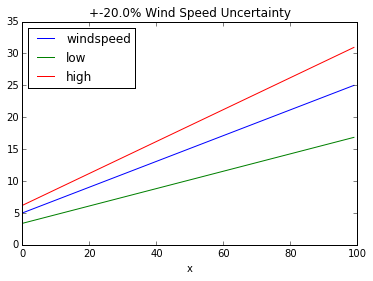

In [14]:
winds = np.linspace(5, 25, 100)
x = range(len(winds))
pu = 0.2

low = [rayleigh_quantile(0.5 - pu, rayleigh_sigma_from_wind(ws))
       for ws in winds]
high = [rayleigh_quantile(0.5 + pu, rayleigh_sigma_from_wind(ws))
        for ws in winds]


fig, ax = plt.subplots()
figure()

ax.plot(x, winds, label="windspeed")
ax.plot(x, low, label="low")
ax.plot(x, high, label="high")

ax.legend(loc=2); # upper left corner
ax.set_xlabel('x')
ax.set_title('+-{0}% Wind Speed Uncertainty'.format(pu * 100))
show()